In this exercise we are going to use Boston Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
url = "https://raw.githubusercontent.com/ga-students/SF-DAT-20/master/Data/Boston.csv"
BostonData = pd.read_csv(url)
del BostonData['Unnamed: 0']
BostonData.head(5)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


#### let's first categorize medv to 4 groups. 
Lowest 20% medv is categorized as Level 1

next 30% medv is categorized as Level 2

next 30% medv is categorized as Level 3

Top 20% medv is categorized as Level 4


In [3]:
BostonData['medvCategory'] = '1'
mask_cat2 = ((BostonData['medv'] > BostonData['medv'].quantile(.2)) & 
            (BostonData['medv'] <= BostonData['medv'].quantile(.5)))   
mask_cat3 = ((BostonData['medv'] > BostonData['medv'].quantile(.5)) & 
            (BostonData['medv'] <= BostonData['medv'].quantile(.8)))  
mask_cat4 = (BostonData['medv'] > BostonData['medv'].quantile(.8)) 

BostonData.loc[mask_cat2,'medvCategory'] = '2'
BostonData.loc[mask_cat3,'medvCategory'] = '3'
BostonData.loc[mask_cat4,'medvCategory'] = '4'

#### Our goal is to predict medvCategory based on 'rm', 'ptratio' and 'lstat'

#### First standardize your input (X) variables - put standardized values in new variables 'rm_st' , 'ptraio_st' and 'lstat_st'

In [4]:
def Standardize(X):
    X_Max = X.max()
    X_Min = X.min()
    X_Standardized = (X-X_Min)/(X_Max - X_Min)
    return X_Standardized

BostonData['rm_st'] = Standardize(BostonData['rm'])
BostonData['ptraio_st'] = Standardize(BostonData['ptratio'])
BostonData['lstat_st'] = Standardize(BostonData['lstat'])
BostonData.head(5)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv,medvCategory,rm_st,ptraio_st,lstat_st
0,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,3,0.577505,0.287234,0.089680
1,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,3,0.547998,0.553191,0.204470
2,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,4,0.694386,0.553191,0.063466
3,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,4,0.658555,0.648936,0.033389
4,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,4,0.687105,0.648936,0.099338


#### Run a KNN classifier with 5 nearest neighbors and report your misclassification error. set weights to uniform

In [5]:

X = BostonData[['rm_st','ptraio_st','lstat_st']]
y = BostonData['medvCategory']
from sklearn import neighbors, metrics
knn = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X,y)
y_hat = knn.predict(X)
Score = knn.score(X,y)

MissClassificationError = 1 - Score
print(MissClassificationError)  #our misclassification error is 21.3% (not bad)

0.213438735178


Is this error reliable?

Answer: No - it can be due to overfit. This is not a validation or cross validation error

#### Now use 10-fold cross-validation to choose the most efficient K (number of neighbors)

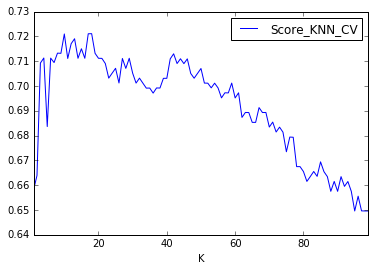

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import cross_validation

kf = cross_validation.KFold(len(BostonData), n_folds = 10, shuffle = True) #10 fold CV
Score_KNN_CV = []
RangeOfK = range(1,100)
scores = []
for k in RangeOfK:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k, weights='uniform')
    scores = []
    for train_index, test_index in kf:        
        knn.fit(X.iloc[train_index], y.iloc[train_index])
        scores.append(knn.score(X.iloc[test_index],y.iloc[test_index]))
    Score_KNN_CV.append(np.mean(scores))

Score_KNN_CV_df = pd.DataFrame({'Score_KNN_CV': Score_KNN_CV ,'K': RangeOfK })
Score_KNN_CV_df.plot(x = 'K',y = 'Score_KNN_CV')

 Explain your findings: It seems like k =20 produces the best result with CV error close to 27%. This error is more than what we found before but way more reliable.

#### Train your algorithm with the optimal K you found above (don't worry if it changes from time to time - if that is the case use the one that is usually the best). After training your model with that K, Use it to predict the class of a neighborhood with rm =2, lstat = 3.5 and ptratio of 19. 

In [7]:
# We shall standardize our input first!
rm_st = (2 - BostonData['rm'].min())/(BostonData['rm'].max()-BostonData['rm'].min())
lstat_st = (3.5 - BostonData['lstat'].min())/(BostonData['lstat'].max()-BostonData['lstat'].min())
ptratio_st =  (19 - BostonData['ptratio'].min())/(BostonData['ptratio'].max()-BostonData['ptratio'].min())


In [8]:
knn = neighbors.KNeighborsClassifier(n_neighbors=20, weights='uniform')
knn.fit(X,y)
x1 = [[rm_st, ptratio_st, lstat_st]]
y_hat = knn.predict(x1)
print(y_hat)
# our prediction is 2

['2']


# Now let's run a KNN-regression model to predict MEDV of the same three points

In [10]:
X = BostonData[['rm_st','ptraio_st','lstat_st']]
y = BostonData['medv']

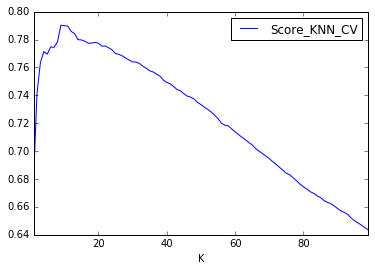

In [13]:
kf = cross_validation.KFold(len(BostonData), n_folds = 10, shuffle = True) #10 fold CV
Score_KNN_CV = []
RangeOfK = range(1,100)
scores = []
for k in RangeOfK:
    knn = neighbors.KNeighborsRegressor(n_neighbors=k, weights='uniform')
    scores = []
    for train_index, test_index in kf:        
        knn.fit(X.iloc[train_index], y.iloc[train_index])
        scores.append(knn.score(X.iloc[test_index],y.iloc[test_index]))
    Score_KNN_CV.append(np.mean(scores))

Score_KNN_CV_df = pd.DataFrame({'Score_KNN_CV': Score_KNN_CV ,'K': RangeOfK })
Score_KNN_CV_df.plot(x = 'K',y = 'Score_KNN_CV')

In [14]:
# it seems like k= 12 is optimal
knn = neighbors.KNeighborsRegressor(n_neighbors=12, weights='uniform')
knn.fit(X,y)
knn.predict(x1)

array([ 22.80833333])

In [15]:
# our prediction is 22.80